In [1]:
%load_ext watermark
%watermark

2017-04-08T15:33:57

CPython 2.7.6
IPython 5.2.2

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [2]:
import tensorflow as tf
import numpy as np
import os
print(tf.__version__)

1.0.0


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
csv_file = './../code/data.csv'

In [42]:
def load_csv_data(file_name):
    dataset = []
    labels = []
    if not os.path.exists(file_name):        
        print csv_file, 'is not existing!'
        return dataset, labels
    
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:            
            items = line.strip('\n').split(',')            
            assert(len(items) == 3)
            dataset.append(items[:2])
            labels.append(items[-1:])
    return dataset, labels
            
train_dataset, train_labels = load_csv_data(csv_file)

num_labels = 2
num_input = 2
data_size = len(train_dataset)

train_dataset = np.array(train_dataset)
train_labels = np.array(train_labels)

print(train_dataset.shape)
print(train_labels.shape)


(200, 2)
(200, 1)


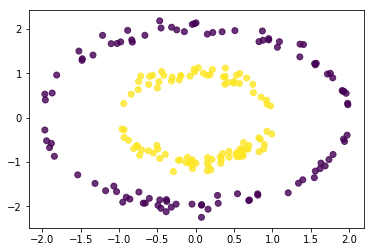

In [6]:
plt.scatter(train_dataset[:,0],train_dataset[:,1],c=train_labels, alpha=0.8)

In [7]:
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, 2)).astype(np.float32)
    
    #create one-hot matrix
    lables_matrix = np.zeros((data_size, num_labels))
    
    i = 0
    for label in labels:
        hot_index = 0
        tmp = float(label[0])
        if (tmp >0.1):
            hot_index = 1
        lables_matrix[i][hot_index] = 1.0
        i += 1
            
    return dataset, lables_matrix

train_dataset, train_labels = reformat(train_dataset, train_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print(train_labels[:10])


('Training set', (200, 2), (200, 2))
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


In [8]:
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [9]:
X = train_dataset

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

print xx.shape, yy.shape

test_dataset = np.c_[xx.ravel(), yy.ravel()]
print test_dataset.shape
#test_dataset = test_dataset.reshape((-1, 2)).astype(np.float32)

testdata_size = test_dataset.shape[0]
print testdata_size

(65, 60) (65, 60)
(3900, 2)
3900


In [36]:
#With hidden layer
batch_size = 100
num_hidden = 20


tf.reset_default_graph()

graph2 = tf.Graph()
with graph2.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, num_input))    
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels)) 
    tf_test_dataset = tf.placeholder(tf.float32, shape=(None, num_input)) 
    
    input_layer = tf.reshape(tf_train_dataset, [-1, num_input])
    
    hidden_layer = tf.layers.dense(inputs=input_layer, units=num_hidden,
                                   activation=tf.nn.tanh) 
    
    output_raw = tf.layers.dense(inputs=hidden_layer, units=num_labels)
    
    train_prediction = tf.nn.sigmoid(output_raw)
    
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf_train_labels, logits=output_raw)
           
    print(input_layer)
    print(hidden_layer)
    print(output_raw)    
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)


Tensor("Reshape:0", shape=(?, 2), dtype=float32)
Tensor("dense/Tanh:0", shape=(?, 20), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 2), dtype=float32)


In [39]:
num_steps = 20000

with tf.Session(graph=graph2) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (data_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = sess.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if ((step+1) % 2000 == 0):
            print("Minibatch loss at step %d: %f" % (step+1, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))

    feed_dict2 = {tf_train_dataset : test_dataset}
    test_predict2 = sess.run(train_prediction, feed_dict=feed_dict2)
                             


Initialized
Minibatch loss at step 2000: 0.658848
Minibatch accuracy: 69.0%
Minibatch loss at step 4000: 0.591680
Minibatch accuracy: 81.0%
Minibatch loss at step 6000: 0.495776
Minibatch accuracy: 86.0%
Minibatch loss at step 8000: 0.382514
Minibatch accuracy: 93.0%
Minibatch loss at step 10000: 0.285425
Minibatch accuracy: 98.0%
Minibatch loss at step 12000: 0.214810
Minibatch accuracy: 99.0%
Minibatch loss at step 14000: 0.166237
Minibatch accuracy: 100.0%
Minibatch loss at step 16000: 0.132944
Minibatch accuracy: 100.0%
Minibatch loss at step 18000: 0.109520
Minibatch accuracy: 100.0%
Minibatch loss at step 20000: 0.092431
Minibatch accuracy: 100.0%


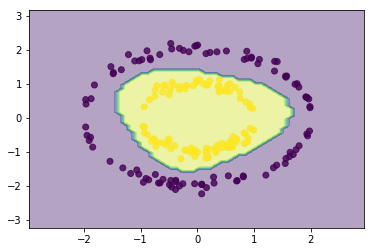

In [40]:
Z = np.argmax(test_predict2, 1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(train_dataset[:,0], train_dataset[:,1],c=np.argmax(train_labels, 1), alpha=0.8)

In [41]:
writer = tf.summary.FileWriter("/root/log", graph=tf.get_default_graph())